In [1]:
import os
os.chdir('mmsegmentation')

In [2]:
os.getcwd()

'/root/mmsegmentation'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import cv2

In [4]:
# 模型 config 配置文件
config_file = 'MyConfigs/Dataset_PSPNe.py'

# 模型 checkpoint 权重文件
checkpoint_file = 'work_dirs/Dataset-PSPNet/best_mIoU_iter_102000.pth'

# device = 'cpu'
device = 'cuda:0'

model = init_model(config_file, checkpoint_file, device=device)

/root/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/root/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: work_dirs/Dataset-PSPNet/best_mIoU_iter_102000.pth


In [5]:
# # 模型 config 配置文件
# config_file = 'Zihao-Configs/ZihaoDataset_FastSCNN_20230818.py'

# # 模型 checkpoint 权重文件
# checkpoint_file = 'checkpoint/Zihao_FastSCNN.pth'

# # device = 'cpu'
# device = 'cuda:0'

# model = init_model(config_file, checkpoint_file, device=device)

In [6]:
# img_path = 'remote_sensing_seg/img_dir/val/T001256.jpg'
# label_path = 'remote_sensing_seg/ann_dir/val/T001256.png'

label_path = 'remote_sensing_seg/ann_dir/val/T008473.png'
img_path = 'remote_sensing_seg/img_dir/val/T008473.jpg'

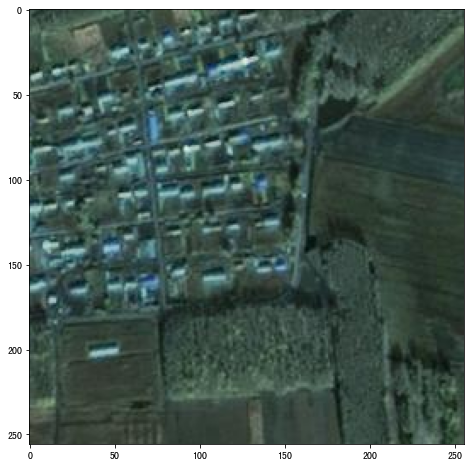

In [7]:
img_bgr = cv2.imread(img_path)
plt.figure(figsize=(8, 8))
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 语义分割预测

In [8]:
result = inference_model(model, img_bgr)

In [9]:
result.keys()

['pred_sem_seg', 'seg_logits']

In [10]:
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

In [11]:
pred_mask.shape

(256, 256)

In [12]:
np.unique(pred_mask)

array([0, 1, 2, 3, 4])

## 语义分割预测结果

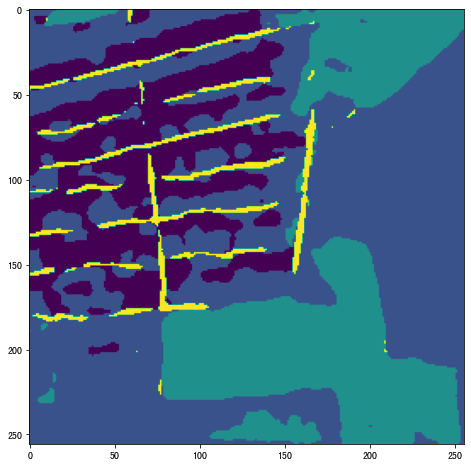

In [13]:
plt.figure(figsize=(8, 8))
plt.imshow(pred_mask)
plt.savefig('outputs/K1-0.jpg')
plt.show()

In [14]:
result.seg_logits.data.shape

torch.Size([7, 256, 256])

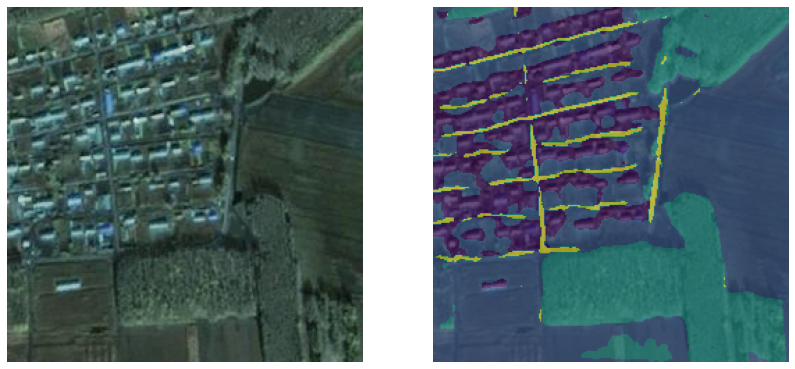

In [16]:
plt.figure(figsize=(14, 8))

plt.subplot(1,2,1)
plt.imshow(img_bgr[:,:,::-1])
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_bgr[:,:,::-1])
plt.imshow(pred_mask, alpha=0.6) # alpha 高亮区域透明度，越小越接近原图
plt.axis('off')
plt.savefig('outputs/K1-2.jpg')
plt.show()

In [17]:
# 各类别的配色方案（BGR）
palette = [
    ['background', [127,127,127]],
    ['red', [0,0,200]],
    ['green', [0,200,0]],
    ['white', [144,238,144]],
    ['seed-black', [30,30,30]],
    ['seed-white', [8,189,251]]
]

palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

In [18]:
palette_dict

{0: [127, 127, 127],
 1: [0, 0, 200],
 2: [0, 200, 0],
 3: [144, 238, 144],
 4: [30, 30, 30],
 5: [8, 189, 251]}

In [19]:
opacity = 0.3 # 透明度，越大越接近原图

In [20]:
# 将预测的整数ID，映射为对应类别的颜色
pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
for idx in palette_dict.keys():
    pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
pred_mask_bgr = pred_mask_bgr.astype('uint8')

# 将语义分割预测图和原图叠加显示
pred_viz = cv2.addWeighted(img_bgr, opacity, pred_mask_bgr, 1-opacity, 0)

cv2.imwrite('outputs/K1-3.jpg', pred_viz)

True

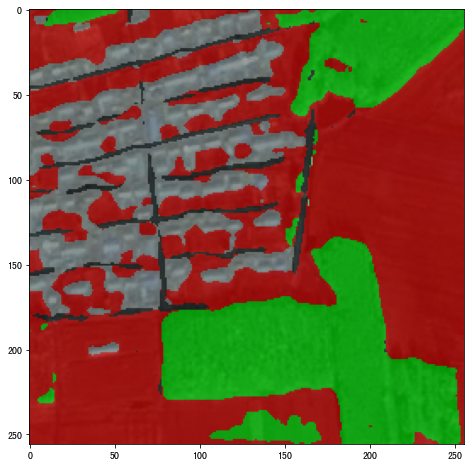

In [21]:
plt.figure(figsize=(8, 8))
plt.imshow(pred_viz[:,:,::-1])
plt.show()

In [22]:
from mmseg.apis import show_result_pyplot

In [23]:
img_viz = show_result_pyplot(model, img_path, result, opacity=0.8, title='MMSeg', out_file='outputs/K1-4.jpg')

/root/miniconda3/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [24]:
img_viz.shape

(256, 256, 3)

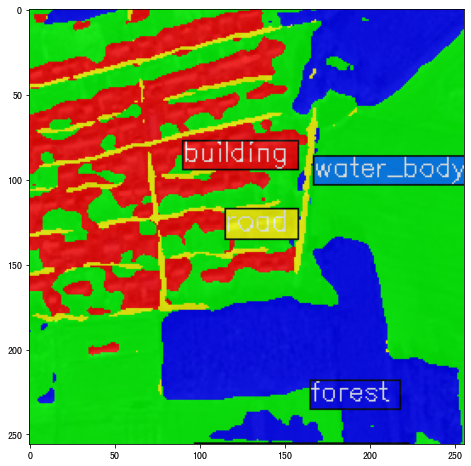

In [25]:
plt.figure(figsize=(14, 8))
plt.imshow(img_viz)
plt.show()

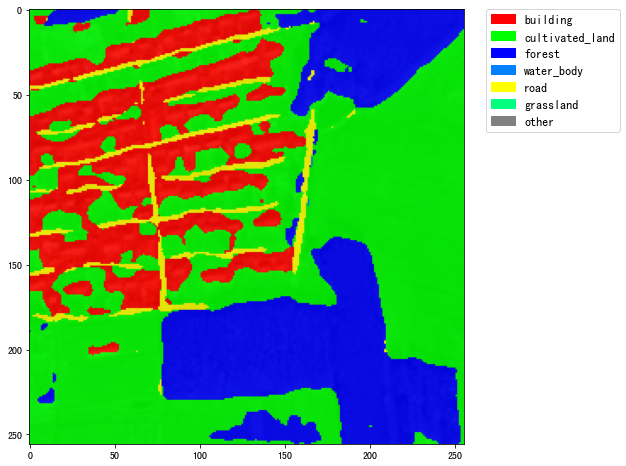

In [26]:
from mmseg.datasets import RemoteSensingDataset
import numpy as np
import mmcv 
from PIL import Image

# 获取类别名和调色板
classes = RemoteSensingDataset.METAINFO['classes']
palette = RemoteSensingDataset.METAINFO['palette']
opacity = 0.15 # 透明度，越大越接近原图

# 将分割图按调色板染色
# seg_map = result[0].astype('uint8')
seg_map = pred_mask.astype('uint8')
seg_img = Image.fromarray(seg_map).convert('P')
seg_img.putpalette(np.array(palette, dtype=np.uint8))

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
plt.figure(figsize=(14, 8))
img_plot = ((np.array(seg_img.convert('RGB')))*(1-opacity) + mmcv.imread(img_path)*opacity) / 255
im = plt.imshow(img_plot)

# 为每一种颜色创建一个图例
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(len(classes))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.savefig('outputs/K1-6.jpg')
plt.show()

## 获取测试集标注

In [27]:
color_mapping = {
    (96, 128, 0): 0,
    (64, 64, 64): 3,
    (192, 128, 0): 5,
    (32, 128, 192): 4,
    (64, 128, 0): 1,
    (0, 128, 64): 2,
    (255, 255, 255): 6,
}

In [28]:
img_path = 'remote_sensing_seg/img_dir/val/T013994.jpg'
label_path = 'remote_sensing_seg/ann_dir/val/T013994.png'

In [29]:
label = cv2.imread(label_path)
label.shape

(256, 256, 3)

In [30]:
# 以十六进制形式输出原数据
original_data_hex = label.astype(np.uint8).view(np.uint8).reshape(label.shape[0], -1)
print("Original Data (Hex):")
print(original_data_hex)

Original Data (Hex):
[[64 64 96 ... 64 64 96]
 [64 64 96 ... 64 64 96]
 [64 64 96 ... 64 64 96]
 ...
 [64 64 96 ... 64 64 96]
 [64 64 96 ... 64 64 96]
 [64 64 96 ... 64 64 96]]


In [31]:
# 读取标签图片
label = cv2.imread(label_path)

# 初始化label_mask
label_mask = np.ones((label.shape[0], label.shape[1]), dtype=np.uint8)*255

# 根据颜色映射填充label_mask
for color, label_value in color_mapping.items():
    mask = np.all(label == np.array(color), axis=-1)
    label_mask[mask] = label_value
    
# 打印结果
print("label_mask.shape:", label_mask.shape)
print("label_mask values:", np.unique(label_mask))

label_mask.shape: (256, 256)
label_mask values: [  2 255]


In [32]:
def read_label_image(label_path):
    # 读取标签图片
    label = cv2.imread(label_path)

    # 转换为灰度图
    gray_label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)

    # 初始化一个空的label_mask
    label_mask = np.full_like(gray_label, 255, dtype=np.uint8)

    # 定义颜色映射
    color_mapping = {
        (96, 128, 0): 0,
        (64, 64, 64): 3,
        (192, 128, 0): 5,
        (32, 128, 192): 4,
        (64, 128, 0): 1,
        (0, 128, 64): 2,
        (255, 255, 255): 6,
    }

    # 遍历颜色映射，将对应颜色的像素值设定为相应的标签值
    for color, label_value in color_mapping.items():
        mask = np.all(label == color, axis=-1)
        label_mask[mask] = label_value

    return label_mask

label_mask = read_label_image(label_path)

# 打印结果
print("label_mask.shape:", label_mask.shape)
print("label_mask values:", np.unique(label_mask))

label_mask.shape: (256, 256)
label_mask values: [  2 255]


In [33]:
import cv2
import numpy as np

# 定义颜色和对应的标签值的映射关系
color_mapping = {
        (96, 128, 0): 0,
        (96, 64, 64): 3,
        (96, 128, 192): 5,
        (32, 128, 192): 4,
        (64, 128, 0): 1,
        (0, 128, 64): 2,
        (255, 255, 255): 6,
    }

# 读取标签图
label = cv2.imread(label_path)

# 创建空白的label_mask
label_mask = np.ones((label.shape[0], label.shape[1]), dtype=np.uint8) * 6

# 根据颜色映射将标签值填充到label_mask中
for color, label_value in color_mapping.items():
    mask = np.all(label == np.array(color), axis=-1)
    label_mask[mask] = label_value

# 打印结果
print("label_mask.shape:", label_mask.shape)
print("label_mask values:", np.unique(label_mask))

label_mask.shape: (256, 256)
label_mask values: [2 6]


In [34]:
# label = cv2.imread(label_path)
# label_mask = label[:,:,1]

# label_mask = label_mask.reshape((256, 256))

In [35]:
np.unique(label_mask)

array([2, 6], dtype=uint8)

In [36]:
np.unique(pred_mask)

array([0, 1, 2, 3, 4])

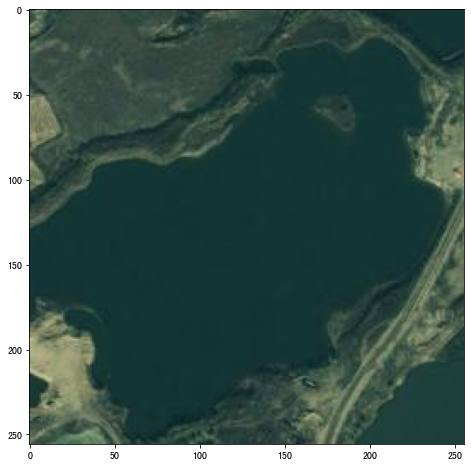

In [37]:
img_bgr = cv2.imread(img_path)
plt.figure(figsize=(8, 8))
plt.imshow(img_bgr[:,:,::-1])
plt.show()

In [39]:
result = inference_model(model, img_bgr)
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()
np.unique(pred_mask)

array([1, 3, 6])

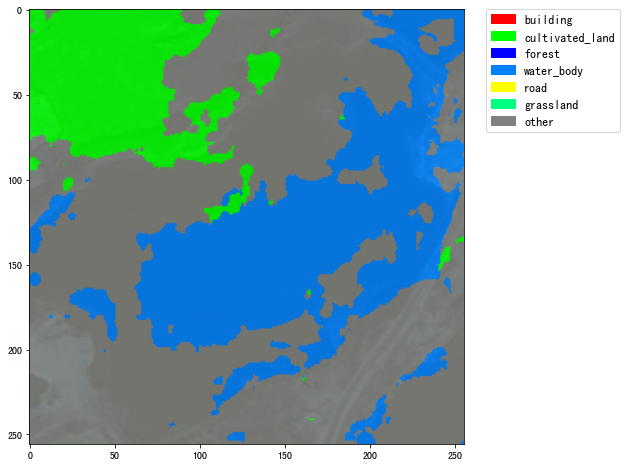

In [40]:
from mmseg.datasets import RemoteSensingDataset
import numpy as np
import mmcv 
from PIL import Image

# 获取类别名和调色板
classes = RemoteSensingDataset.METAINFO['classes']
palette = RemoteSensingDataset.METAINFO['palette']
opacity = 0.15 # 透明度，越大越接近原图

# 将分割图按调色板染色
# seg_map = result[0].astype('uint8')
seg_map = pred_mask.astype('uint8')
seg_img = Image.fromarray(seg_map).convert('P')
seg_img.putpalette(np.array(palette, dtype=np.uint8))

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
plt.figure(figsize=(14, 8))
img_plot = ((np.array(seg_img.convert('RGB')))*(1-opacity) + mmcv.imread(img_path)*opacity) / 255
im = plt.imshow(img_plot)

# 为每一种颜色创建一个图例
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(len(classes))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.show()

|种类|对应值|颜色值（十六进制）|颜色值（二进制）|
|---|---|---|---|
|building        |0   |608000|0110 0000 1000 0001 0000 0000|
|cultivated_land |1   |408000|0100 0000 1000 0000 0000 0000|
|forest          |2   |008040|0000 0000 1000 0000 0100 0000|
|water_body      |3   |604040|0110 0000 0100 0000 0100 0000|
|road            |4   |2080c0|0010 0001 1000 0000 1100 0000|
|grassland       |5   |6080c0|0110 0001 1000 0000 1100 0000|
|other           |255 |ffffff|1111 1111 1111 1111 1111 1111|

## 对比测试集标注和语义分割预测结果

In [41]:
# 测试集标注
label_mask.shape

(256, 256)

In [42]:
# 语义分割预测结果
pred_mask.shape

(256, 256)